In [1]:
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from xmovie import Movie
import matplotlib.path as mpath
import cartopy.feature as cft
import numpy as np

import warnings
warnings.filterwarnings("ignore") # Suppress warnings for these docs

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

<Client: 'tcp://127.0.0.1:46001' processes=21 threads=21, memory=765.00 GiB>

2025-10-17 13:00:11,152 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 8aa7091bc4cc1f4ecfb3b295e97fe47a initialized by task ('rechunk-transfer-b1b9cc1d1a174fe7ffe9e0d8bf5bd6d1', 0, 0, 0, 4, 0, 0) executed on worker tcp://127.0.0.1:42509
2025-10-17 13:00:11,175 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5319efb5a8a63c17911f6d6a3f545d3d initialized by task ('rechunk-transfer-b1b9cc1d1a174fe7ffe9e0d8bf5bd6d1', 0, 0, 2, 4, 0, 2) executed on worker tcp://127.0.0.1:32907
2025-10-17 13:00:11,214 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 306f091fc35808a342e84c66d9ac06e3 initialized by task ('rechunk-transfer-b1b9cc1d1a174fe7ffe9e0d8bf5bd6d1', 0, 0, 1, 4, 0, 1) executed on worker tcp://127.0.0.1:40717
2025-10-17 13:00:11,459 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e3c383362ddcb0f0b5643d95615e41f7 initialized by task ('rechunk-transfer-b1b9cc1d1a174fe7ffe9e0d8bf5bd6d1', 0, 0, 3, 4, 0, 3) executed on worker tcp://127.0.0.1:40717


In [3]:
import cosima_cookbook as cc
db = 'local_cc_scratch_Ryan_data.db'
session = cc.database.create_session(db)

## Load in SSTA

In [4]:
## CLIMATOLOGIES
pattern = '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/JRA_SST_Processed/Climatology/*nc'

import xarray as xr 

def select_sst_only(ds):
    return ds[["sst"]]

Seas = xr.open_mfdataset(
          pattern,
          combine="by_coords",        
          parallel=True,
          preprocess=select_sst_only
)

In [5]:
## THRESHOLDS
pattern = "/g/data/e14/ts7341/Analysis_Using_Daily_JRA/JRA_SST_Processed/Thresholds90thPercentile/*.nc"

Thresh = xr.open_mfdataset(
    pattern,
    combine="by_coords",        
    parallel=True,              
)

In [6]:
# Shift 'Thresh' dayofyear from 0-365 to 1-366
Thresh = Thresh.assign_coords(dayofyear=Thresh['dayofyear'] + 1)

In [7]:
ds = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='surface_temp', 
                          session=session, frequency='1 daily',
                          attrs={'cell_methods': 'time: mean'},
                          chunks={'time': -1, 'xt_ocean': '400MB', 'yt_ocean': '400MB'})

In [8]:
ds = ds.sel(yt_ocean = slice(-82,-50)).sel(xt_ocean = slice(-280,80))
ds = ds.sel(time=slice('2010-01-01', '2023-12-31'))
print(ds)

<xarray.DataArray 'surface_temp' (time: 5111, yt_ocean: 266, xt_ocean: 1440)> Size: 8GB
dask.array<getitem, shape=(5111, 266, 1440), dtype=float32, chunksize=(366, 266, 480), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 2kB -81.08 -80.97 -80.87 ... -50.3 -50.14
  * time      (time) datetime64[ns] 41kB 2010-01-01T12:00:00 ... 2023-12-29T1...
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_conservative_temperature
    ncfiles:        ['/g/data/e14/rmh561/access-om2/archive/025deg_jra55_iaf_...
    contact:        Ryan Holmes
    email:          ryan.holmes@unsw.edu.au
    created:        2020-11-03
    description:    0.25 degree ACCESS-OM2 global model configuration under i...


In [9]:
# # Rename dimensions
ds = ds.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})

# # Convert surface_temp from Kelvin to Celsius
ds_input = ds - 273.15
ds_input.attrs['units'] = 'deg C'  # Update units attribute

# # Display the modified dataset structure
ds_input = ds_input

In [10]:
ds_input = ds_input.assign_coords(dayofyear=ds_input['time'].dt.dayofyear)
print(ds_input)

<xarray.DataArray 'surface_temp' (time: 5111, lat: 266, lon: 1440)> Size: 8GB
dask.array<sub, shape=(5111, 266, 1440), dtype=float32, chunksize=(366, 266, 480), chunktype=numpy.ndarray>
Coordinates:
  * lon        (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * lat        (lat) float64 2kB -81.08 -80.97 -80.87 ... -50.46 -50.3 -50.14
  * time       (time) datetime64[ns] 41kB 2010-01-01T12:00:00 ... 2023-12-29T...
    dayofyear  (time) int64 41kB 1 2 3 4 5 6 7 8 ... 357 358 359 360 361 362 363
Attributes:
    units:    deg C


In [11]:
import xarray as xr

Seas_aligned = Seas.interp(
    dayofyear=xr.DataArray(ds_input['dayofyear'].values, dims="time")
)

In [12]:
Seas_aligned = Seas_aligned.sst
Thresh_aligned = Thresh.sel(dayofyear=ds_input['dayofyear'])

In [13]:
Thresh_aligned = Thresh.sel(dayofyear=ds_input['dayofyear'])
Seas_aligned = Seas.sel(dayofyear=ds_input['dayofyear'])

In [14]:
SSTa = ds_input - Seas_aligned
SSTa = SSTa.chunk({'time':-1,'lon':'300MB','lat':'300MB'})

In [15]:
ml_temp = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='temp_in_mld', 
                          session=session, frequency='1 daily',
                          attrs={'cell_methods': 'time: mean'},
                          chunks={'time': -1, 'xt_ocean': '400MB', 'yt_ocean': '400MB'})

In [16]:
ml_temp

<xarray.DataArray 'temp_in_mld' (time: 16801, yt_ocean: 1080, xt_ocean: 1440)> Size: 105GB
dask.array<concatenate, shape=(16801, 1080, 1440), dtype=float32, chunksize=(366, 432, 480), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 134kB 1977-12-30T12:00:00 ... 2023-12-29T...
Attributes:
    long_name:      tracer averaged in mixed layer * rho for tracer Conservat...
    units:          deg_C kg m-3
    valid_range:    [-1.e+16  1.e+16]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    ncfiles:        ['/g/data/e14/rmh561/access-om2/archive/025deg_jra55_iaf_...
    contact:        Ryan Holmes
    email:          ryan.holmes@unsw.edu.au
    created:        2020-11-03
    description:    0.25 degree ACCESS-OM2 global model configuration under i...

## Sea Ice Data

In [17]:
ice = xr.open_mfdataset(['/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1982_1988.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1989_1996.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1997_2004.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2005_2011.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2012_2015.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2016-2022.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2023.nc'])
ice_new = xr.open_mfdataset('/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/hi_m_and_congel/*.nc')
ice_clim_access = xr.open_mfdataset('/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_climatologies/*.nc')

In [18]:
ice = ice.assign_coords(dayofyear=ice['time'].dt.dayofyear).sel(time = slice('1982','2023-12-29'))
ice_new = ice_new.assign_coords(dayofyear=ice_new['time'].dt.dayofyear).sel(time = slice('1982','2023-12-29'))

In [19]:
access_clim = ice_clim_access.sel(dayofyear=ice['dayofyear'])
access_clim = access_clim.assign_coords(dayofyear=ice['time'].dt.dayofyear).sel(time = slice('2000','2024'))
access_clim

<xarray.Dataset> Size: 118GB
Dimensions:    (yt_ocean: 233, xt_ocean: 1440, time: 8764)
Coordinates:
    TLON       (yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(233, 1440), meta=np.ndarray>
    TLAT       (yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(233, 1440), meta=np.ndarray>
    ULON       (yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(233, 1440), meta=np.ndarray>
    ULAT       (yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(233, 1440), meta=np.ndarray>
  * xt_ocean   (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * yt_ocean   (yt_ocean) float64 2kB -81.08 -80.97 -80.87 ... -55.28 -55.14
    dayofyear  (time) int64 70kB 1 2 3 4 5 6 7 8 ... 357 358 359 360 361 362 363
  * time       (time) datetime64[ns] 70kB 2000-01-01T12:00:00 ... 2023-12-29T...
Data variables:
    aice       (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>
    congel     (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>
    daidtd     (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>
    daidtt     (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>
    dvidtd     (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>
    dvidtt     (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>
    frazil     (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>
    hi         (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>
    meltb      (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>
    meltt      (yt_ocean, xt_ocean, time) float32 12GB dask.array<chunksize=(233, 1440, 14), meta=np.ndarray>

In [20]:
anom = ice - access_clim
anom_1 = ice_new - access_clim

In [21]:
anomaly = anom.aice
anomaly = anomaly
anomaly

<xarray.DataArray 'aice' (time: 8764, yt_ocean: 233, xt_ocean: 1440)> Size: 12GB
dask.array<sub, shape=(8764, 233, 1440), dtype=float32, chunksize=(366, 34, 206), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 70kB 2000-01-01T12:00:00 ... 2023-12-29T...
  * xt_ocean   (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * yt_ocean   (yt_ocean) float64 2kB -81.08 -80.97 -80.87 ... -55.28 -55.14
    TLON       (yt_ocean, xt_ocean) float32 1MB nan nan nan ... 79.62 79.88
    TLAT       (yt_ocean, xt_ocean) float32 1MB nan nan nan ... -55.14 -55.14
    ULON       (yt_ocean, xt_ocean) float32 1MB nan nan nan ... 79.25 79.5 79.75
    ULAT       (yt_ocean, xt_ocean) float32 1MB nan nan nan ... -55.07 -55.07
    dayofyear  (time) int64 70kB 1 2 3 4 5 6 7 8 ... 357 358 359 360 361 362 363

## Select Model Data for the Region of the Heat Budget

In [22]:
yt_coord = slice(-68, -63)
xt_coord = slice(-20, 10)
area = cc.querying.getvar(
    expt='025deg_jra55_iaf_cycle6_online_mlt',
    variable='area_t', 
    session=session,
    frequency='static',
    attrs={'cell_methods': 'time: point'},
    n=1
)
area = area.sel(yt_ocean=yt_coord, xt_ocean = xt_coord).load()

In [23]:
# -----------------------------
# Robust area-weighted block averaging function
# -----------------------------
def block_average_area_weighted(arr, area, block_size_lat, block_size_lon):
    """
    Compute area-weighted block averages of a 2D array.
    Handles NaNs and blocks with zero total weight.
    """
    arr = np.array(arr)
    weights = np.array(area)
    
    n_lat, n_lon = arr.shape
    n_blocks_lat = int(np.ceil(n_lat / block_size_lat))
    n_blocks_lon = int(np.ceil(n_lon / block_size_lon))

    result = np.full((n_blocks_lat, n_blocks_lon), np.nan)

    for i in range(n_blocks_lat):
        for j in range(n_blocks_lon):
            # Define block slices
            lat_start = i * block_size_lat
            lat_end = min((i + 1) * block_size_lat, n_lat)
            lon_start = j * block_size_lon
            lon_end = min((j + 1) * block_size_lon, n_lon)

            arr_block = arr[lat_start:lat_end, lon_start:lon_end]
            weights_block = weights[lat_start:lat_end, lon_start:lon_end]

            # Mask NaNs
            valid_mask = ~np.isnan(arr_block) & ~np.isnan(weights_block)
            if np.any(valid_mask):
                weighted_sum = np.sum(arr_block[valid_mask] * weights_block[valid_mask])
                total_weight = np.sum(weights_block[valid_mask])
                if total_weight > 0:
                    result[i, j] = weighted_sum / total_weight
    return result

In [24]:
time = slice('2016-11-01','2017-05-31')
yt_ocean = slice(-68,-63)
xt_ocean = slice(-20,10)

# -----------------------------
# Subset area for weighting
# -----------------------------
area_ice = area.sel(yt_ocean=yt_ocean, xt_ocean=xt_ocean)
area_sst = area.sel(yt_ocean=yt_ocean, xt_ocean=xt_ocean)
area_ml = area.sel(yt_ocean=yt_ocean, xt_ocean=xt_ocean)

# -----------------------------
# Sea Ice
# -----------------------------
ice_point = ice.aice.sel(time=time, yt_ocean=yt_ocean, xt_ocean=xt_ocean)\
                   .weighted(area).mean(dim=['yt_ocean', 'xt_ocean'])

ice_point_anom = anom.aice.sel(time=time, yt_ocean=yt_ocean, xt_ocean=xt_ocean)\
                          .weighted(area).mean(dim=['yt_ocean', 'xt_ocean'])

clim_anom = access_clim.aice.sel(time=time, yt_ocean=yt_ocean, xt_ocean=xt_ocean)\
                            .weighted(area).mean(dim=['yt_ocean', 'xt_ocean'])

# -----------------------------
# SST
# -----------------------------
seas = Seas_aligned.sel(time=time, lat=yt_ocean, lon=xt_ocean)\
                    .weighted(area).mean(dim=['lat','lon'])

seasonal = seas.sst

thresh = Thresh_aligned.sel(time=time, lat=yt_ocean, lon=xt_ocean)\
                       .weighted(area).mean(dim=['lat','lon'])

temp_point = ds_input.sel(time=time, lat=yt_ocean, lon=xt_ocean)\
                     .weighted(area).mean(dim=['lat','lon'])

# -----------------------------
# Mixed Layer Temperature
# -----------------------------
ml_temp_point = ml_temp.sel(time=time, yt_ocean=yt_ocean, xt_ocean=xt_ocean)\
                       .weighted(area).mean(dim=['yt_ocean','xt_ocean'])

ml_temp_point = ml_temp_point / 1035  # convert units

# -----------------------------
# Keep full model arrays for reference
# -----------------------------
access_clim_aice = access_clim.aice
access_aice = ice.aice


In [25]:
time = slice('2016-11-01','2017-05-31')
yt_ocean = slice(-68,-63)
xt_ocean = slice(-20,10)

ice_point = ice.aice.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean'])

ice_point_anom = anom.aice.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean'])

clim_anom = access_clim.aice.sel(time = time).\
                      sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean'])

seas = Seas_aligned.sel(time = time)\
                      .sel(lat = yt_ocean, lon = xt_ocean)\
                      .mean(['lon','lat'])

seasonal = seas.sst

thresh = Thresh_aligned.sel(time = time)\
                      .sel(lat = yt_ocean, lon = xt_ocean)\
                      .mean(['lon','lat'])

thresh = thresh.__xarray_dataarray_variable__ 
thresh = thresh 

temp_point = ds_input.sel(time = time)\
                      .sel(lat = yt_ocean, lon = xt_ocean)\
                      .mean(['lon','lat'])

ml_temp_point = ml_temp.sel(time = time)\
                       .sel(yt_ocean = yt_ocean, xt_ocean = xt_ocean)\
                      .mean(['xt_ocean','yt_ocean'])
ml_temp_point = ml_temp_point
ml_temp_point = ml_temp_point/1035

access_clim_aice = access_clim.aice
access_aice = ice.aice

## Load NOAA Data

### Sea Ice

In [26]:
import glob
import xarray as xr
import re

import xarray as xr

import xarray as xr

# Open only 2000–2023 files
sea_ice = xr.open_mfdataset(
    [
        f'/g/data/e14/ts7341/NOAA Data/NOAA OISST Sea Ice/icec.day.mean.{year}.nc'
        for year in range(1982, 2024)
    ],
    combine='by_coords',
        chunks={'time': 365}  # chunk by year to reduce memory usage
)

# Select Antarctic region (latitudes south of -55)
sea_ice = sea_ice.sel(lat=slice(-90, -55))


In [27]:
ice_clim = xr.open_dataset('/g/data/e14/ts7341/NOAA Data/NOAA OISST Sea Ice/ice_clim.nc')
ice_clim

<xarray.Dataset> Size: 295MB
Dimensions:    (lat: 140, lon: 1440, dayofyear: 366)
Coordinates:
  * lat        (lat) float32 560B -89.88 -89.62 -89.38 ... -55.62 -55.38 -55.12
  * lon        (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Data variables:
    icec       (lat, lon, dayofyear) float32 295MB ...

In [28]:
# Assign dayofyear to c_ice
c_ice = sea_ice.assign_coords(dayofyear=sea_ice['time'].dt.dayofyear)

# Align climatology using dayofyear and assign dates from temp
climatology_ice = ice_clim.sel(dayofyear=c_ice['dayofyear'])
climatology_ice = climatology_ice.icec.assign_coords(time=c_ice['time'])


### SSTA

In [29]:
import glob
import xarray as xr
import re

# Get a list of all NetCDF files
filelist = glob.glob('/g/data/e14/asg561/MHW_xarray/mhw_data_90pc/mhw*.nc')

# Define a regex pattern to match latitudes -90to-70 or -70to-50
pattern = re.compile(r'\.(-90to-70|-70to-50)\.')

# Filter the file list based on the pattern
filtered_files = [f for f in filelist if pattern.search(f)]

# Check if there are matching files
if filtered_files:
    # Open only the filtered files
    satellite_data = xr.open_mfdataset(filtered_files, combine='by_coords')
    print(satellite_data)
else:
    print("No matching files found!")

satellite_data

<xarray.Dataset> Size: 59GB
Dimensions:         (time: 15688, lat: 160, lon: 1440, time366: 366)
Coordinates:
  * lat             (lat) float32 640B -89.88 -89.62 -89.38 ... -50.38 -50.12
  * lon             (lon) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time            (time) datetime64[ns] 126kB 1981-12-30 ... 2024-12-11
  * time366         (time366) datetime64[ns] 3kB 1983-12-30 ... 1984-12-29
Data variables:
    severity        (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    severity_index  (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    ssta            (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    sst             (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    climatology90   (time366, lat, lon) float32 337MB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    climatology     (time366, lat, lon) float32 337MB d

<xarray.Dataset> Size: 59GB
Dimensions:         (time: 15688, lat: 160, lon: 1440, time366: 366)
Coordinates:
  * lat             (lat) float32 640B -89.88 -89.62 -89.38 ... -50.38 -50.12
  * lon             (lon) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time            (time) datetime64[ns] 126kB 1981-12-30 ... 2024-12-11
  * time366         (time366) datetime64[ns] 3kB 1983-12-30 ... 1984-12-29
Data variables:
    severity        (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    severity_index  (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    ssta            (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    sst             (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    climatology90   (time366, lat, lon) float32 337MB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    climatology     (time366, lat, lon) float32 337MB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
Attributes:
    history:  Created in regional_MHW_hdd4_anomaly.py pctile=902025-01-06 14:...

In [30]:
# --- SST ---
# Select longitude from 355 to 360 and from 0 to 10, then concatenate
sst_part1 = satellite_data.sst.sel(lat=slice(-68, -63), lon=slice(340, 360))
sst_part2 = satellite_data.sst.sel(lat=slice(-68, -63), lon=slice(0, 10))
sst_combined = xr.concat([sst_part1, sst_part2], dim='lon')
temp = sst_combined.mean(dim=['lat', 'lon'])
sst = temp.sel(time=slice('2016-11-01', '2017-05-31'))

# --- Sea Ice Concentration ---
c_ice_part1 = sea_ice.icec.sel(lat=slice(-68, -63), lon=slice(340, 360))
c_ice_part2 = sea_ice.icec.sel(lat=slice(-68, -63), lon=slice(0, 10))
c_ice_combined = xr.concat([c_ice_part1, c_ice_part2], dim='lon')

# Replace NaNs with 0 and calculate mean
c_ice = c_ice_combined.sel(time=slice('2016-11-01', '2017-05-31')).fillna(0).mean(dim=['lat', 'lon'])

# --- Climatology Ice --- (Have to use logical conditions instead of slice because of errors??)
# Use logical conditions instead of sel(slice(...)) to avoid KeyErrors
c_ice_part1 = climatology_ice.where(
    (climatology_ice.lat >= -70) & (climatology_ice.lat <= -63) &
    (climatology_ice.lon >= 345),
    drop=True
)
c_ice_part2 = climatology_ice.where(
    (climatology_ice.lat >= -70) & (climatology_ice.lat <= -63) &
    (climatology_ice.lon <= 10),
    drop=True
)
c_ice_combined = xr.concat([c_ice_part1, c_ice_part2], dim='lon')
climate_ice = c_ice_combined.sel(time=slice('2016-11-01', '2017-05-31')).mean(dim=['lat', 'lon'])

# --- Climatology 90 ---
clim_part1 = satellite_data.climatology90.sel(lat=slice(-68, -63), lon=slice(340, 360))
clim_part2 = satellite_data.climatology90.sel(lat=slice(-68, -63), lon=slice(0, 10))
clim_combined = xr.concat([clim_part1, clim_part2], dim='lon')
clim = clim_combined.mean(dim=['lat', 'lon'])

# --- Climatology ---
climate_part1 = satellite_data.climatology.sel(lat=slice(-68, -63), lon=slice(340, 360))
climate_part2 = satellite_data.climatology.sel(lat=slice(-68, -63), lon=slice(0, 10))
climate_combined = xr.concat([climate_part1, climate_part2], dim='lon')
climate = climate_combined.mean(dim=['lat', 'lon'])

In [31]:
import numpy as np
import xarray as xr

# --- 1. Assign DOY (day-of-year) to `temp` ---
sst = sst.assign_coords(doy=sst['time'].dt.dayofyear)

# --- 2. Assign DOY 1–366 to the climatology datasets ---

# This assumes your climatology and climatology90 each have 366 entries
doy_full = np.arange(1, 367)

# Assign DOY as a coordinate
climatology = clim.assign_coords(doy=('time366', doy_full))
climatology90 = climate.assign_coords(doy=('time366', doy_full))
 
# Swap dimension so we can index by DOY instead of time366
climatology = climatology.swap_dims({'time366': 'doy'})
climatology90 = climatology90.swap_dims({'time366': 'doy'})

# --- 3. Align climatology with temp using DOY ---

# Select climatology using the DOY from temp, aligned over time
sst_clim = climatology.sel(doy=xr.DataArray(sst['doy'].values, dims='time'))
sst_clim = sst_clim.assign_coords(time=sst['time'])

# Repeat for threshold climatology
sst_clim90 = climatology90.sel(doy=xr.DataArray(sst['doy'].values, dims='time'))
sst_clim90 = sst_clim90.assign_coords(time=sst['time'])

sst_clim90.load()
sst_clim.load()
sst.load()
c_ice.load()

<xarray.DataArray 'icec' (time: 212)> Size: 848B
array([8.85858357e-01, 8.70666683e-01, 8.56779158e-01, 8.38387489e-01,
       8.16616595e-01, 8.09712470e-01, 8.03387463e-01, 7.98366606e-01,
       7.95691609e-01, 7.94066668e-01, 7.95954168e-01, 7.89862514e-01,
       7.82170832e-01, 7.77504146e-01, 7.73187459e-01, 7.64933288e-01,
       7.40991652e-01, 7.30120838e-01, 7.17766702e-01, 7.12558270e-01,
       6.97137475e-01, 6.77645802e-01, 6.67583287e-01, 6.49562538e-01,
       6.26137495e-01, 6.04145825e-01, 5.82716703e-01, 5.51683366e-01,
       5.24524987e-01, 5.05079150e-01, 4.88099962e-01, 4.74499971e-01,
       4.63212490e-01, 4.46758270e-01, 4.33395803e-01, 4.17025030e-01,
       3.97933364e-01, 3.86262476e-01, 3.80724996e-01, 3.75895828e-01,
       3.50874960e-01, 3.17637473e-01, 2.07625002e-01, 1.77329168e-01,
       1.62108332e-01, 1.62108332e-01, 1.52420819e-01, 1.31395832e-01,
       1.06204167e-01, 8.66499990e-02, 7.56208301e-02, 6.62791654e-02,
       6.13083318e-02, 5.34041673e-02, 4.03374992e-02, 3.17708328e-02,
       2.18083318e-02, 1.80041641e-02, 1.34333344e-02, 1.14749996e-02,
       1.10750003e-02, 7.58749945e-03, 1.38333335e-03, 2.29166675e-04,
       2.29166675e-04, 7.91666680e-05, 7.49999963e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
...
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.91666656e-04,
       7.24999991e-04, 7.45833328e-04, 9.04166722e-04, 1.00833341e-03,
       9.54166637e-04, 9.29166679e-04, 4.70833329e-04, 6.50000002e-04,
       5.16666682e-04, 5.00000024e-04, 5.33333339e-04, 5.66666655e-04,
       3.73333343e-03, 8.28333292e-03, 1.62208322e-02, 2.20583323e-02,
       2.23708339e-02, 2.36374997e-02, 2.58583315e-02, 2.61916649e-02,
       2.86500007e-02, 2.84666643e-02, 3.99208330e-02, 5.20291664e-02,
       6.44416660e-02, 9.55083370e-02, 1.18329175e-01, 1.33762494e-01,
       1.49262488e-01, 1.65333331e-01, 1.94075003e-01, 2.50045836e-01,
       3.09199989e-01, 3.47004175e-01, 3.63787502e-01, 3.61183345e-01,
       3.84566665e-01, 4.07245845e-01, 4.13812488e-01, 4.30012524e-01,
       4.41408336e-01, 4.35262501e-01, 4.37820852e-01, 4.41508323e-01,
       4.32549983e-01, 4.30762470e-01, 4.36825007e-01, 4.52225000e-01],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2016-11-01 2016-11-02 ... 2017-05-31

## Make First Part of Figure 2 from Manuscript (a. and b.)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

#Style Parameters
plt.rcParams.update({
    'font.family': 'DejaVu Sans',  # Closest to Arial I was able to find, trying to keep it consistent for when I use InkScape
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'xtick.labelsize': 26,
    'ytick.labelsize': 26,
    'legend.fontsize': 18,
    'figure.dpi': 300,
})

labelsize = 20

# Figure
fig = plt.figure(figsize=(20, 16))
gs = plt.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.4)


# Panel a: OISST 
ax_a = fig.add_subplot(gs[0])
time_oisst = sst['time'].values
sst_vals_oisst = sst.values
thresh_vals_oisst = sst_clim.values
seas_vals_oisst = sst_clim90.values
ice_vals_oisst = c_ice.values
ice_vals_masked_oisst = np.where(ice_vals_oisst < 0.15, np.nan, ice_vals_oisst)

# Plot OISST
ax_a.plot(time_oisst, sst_vals_oisst, color='black', linewidth=2.5, label='SST')
ax_a.plot(time_oisst, thresh_vals_oisst, color='steelblue', linestyle=':', linewidth=2, label='Threshold')
ax_a.plot(time_oisst, seas_vals_oisst, color='darkorange', linestyle='--', linewidth=2, label='Climatology')
ax_a.fill_between(time_oisst, sst_vals_oisst, thresh_vals_oisst,
                  where=(sst_vals_oisst > thresh_vals_oisst), color='red', alpha=0.6, label='MHW')

# Secondary y-axis (sea-ice)
ax_a_sec = ax_a.twinx()
ax_a_sec.plot(time_oisst, ice_vals_masked_oisst, color='green', linewidth=2, linestyle='-.', label='Sea-Ice')

# Styling
ax_a.set_title("a. OISSTv2.1", loc='left', fontweight='bold')
ax_a.set_ylabel('Temperature (°C)')
ax_a.set_ylim(-2, 3)
ax_a.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax_a.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax_a.tick_params(labelsize=labelsize)
ax_a.grid(True, linestyle='--', alpha=0.5)

# Sea-ice axis as percentage
ax_a_sec.set_ylabel('Sea-Ice Concentration (%)')
ax_a_sec.set_ylim(0, 1.0)
ax_a_sec.set_yticks(np.arange(0, 1.01, 0.2))
ax_a_sec.set_yticklabels([f'{int(t*100)}' for t in np.arange(0, 1.01, 0.2)])
ax_a_sec.tick_params(labelsize=labelsize)

# Panel b: ACCESS 
ax_b = fig.add_subplot(gs[1])
time_access = temp_point['time'].values
sst_vals_access = temp_point.values
thresh_vals_access = thresh.values
seas_vals_access = seasonal.values
ml_temp_vals = ml_temp_point
ice_vals_access = ice_point.values
ice_vals_masked_access = np.where(ice_vals_access < 0.15, np.nan, ice_vals_access)

# Plot ACCESS
ax_b.plot(time_access, sst_vals_access, color='black', linewidth=2.5, label='SST')
ax_b.plot(time_access, thresh_vals_access, color='steelblue', linestyle=':', linewidth=2, label='90th Percentile')
ax_b.plot(time_access, seas_vals_access, color='darkorange', linestyle='--', linewidth=2, label='Climatology')
ax_b.plot(time_access, ml_temp_vals, color='gray', linestyle='--', linewidth=2, label='ML Temp')
ax_b.fill_between(time_access, sst_vals_access, thresh_vals_access,
                  where=(sst_vals_access > thresh_vals_access), color='red', alpha=0.6, label='MHW')

# Secondary y-axis (sea-ice)
ax_b_sec = ax_b.twinx()
ax_b_sec.plot(time_access, ice_vals_masked_access, color='green', linewidth=2, linestyle='-.', label='Sea-Ice Concentration')

# Styling
ax_b.set_title("b. ACCESS-OM2", loc='left', fontweight='bold')
ax_b.set_xlabel('Time', labelpad = 5)
ax_b.set_ylabel('Temperature (°C)')
ax_b.set_ylim(-2, 3)
ax_b.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax_b.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax_b.tick_params(labelsize=labelsize)
ax_b.grid(True, linestyle='--', alpha=0.5)

# Sea-ice axis as percentage
ax_b_sec.set_ylabel('Sea-Ice Concentration (%)')
ax_b_sec.set_ylim(0, 1.0)
ax_b_sec.set_yticks(np.arange(0, 1.01, 0.2))
ax_b_sec.set_yticklabels([f'{int(t*100)}' for t in np.arange(0, 1.01, 0.2)])
ax_b_sec.tick_params(labelsize=labelsize)


# Legend
import matplotlib.lines as mlines
lines = [
    mlines.Line2D([], [], color='black', linewidth=2.5, label='Sea Surface Temperature'),
    mlines.Line2D([], [], color='steelblue', linewidth=2.5, linestyle=':', label='90th-Percentile Temperature'),
    mlines.Line2D([], [], color='darkorange', linewidth=2.5, linestyle='--', label='Climatological Temperature'),
    mlines.Line2D([], [], color='gray', linewidth=2.5, linestyle='--', label='Mixed-Layer Temperature'),
    mlines.Line2D([], [], color='green', linewidth=2.5, linestyle='-.', label='Sea-Ice Concentration'),
    mlines.Line2D([], [], color='red', linewidth=6, alpha=0.6, label='MHW Conditions')
]

fig.subplots_adjust(bottom=0.2)
fig.legend(lines, [l.get_label() for l in lines], loc='lower center',
           bbox_to_anchor=(0.5, .07), ncol=3, frameon=False, fontsize=labelsize, handlelength=2)

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.savefig('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/Weddell_Sea_MHW_Time_Series.png',
            dpi=800, bbox_inches='tight', pad_inches=0.1)
plt.show()


## Make First Part of Figure 2 from Manuscript (c. to h.)

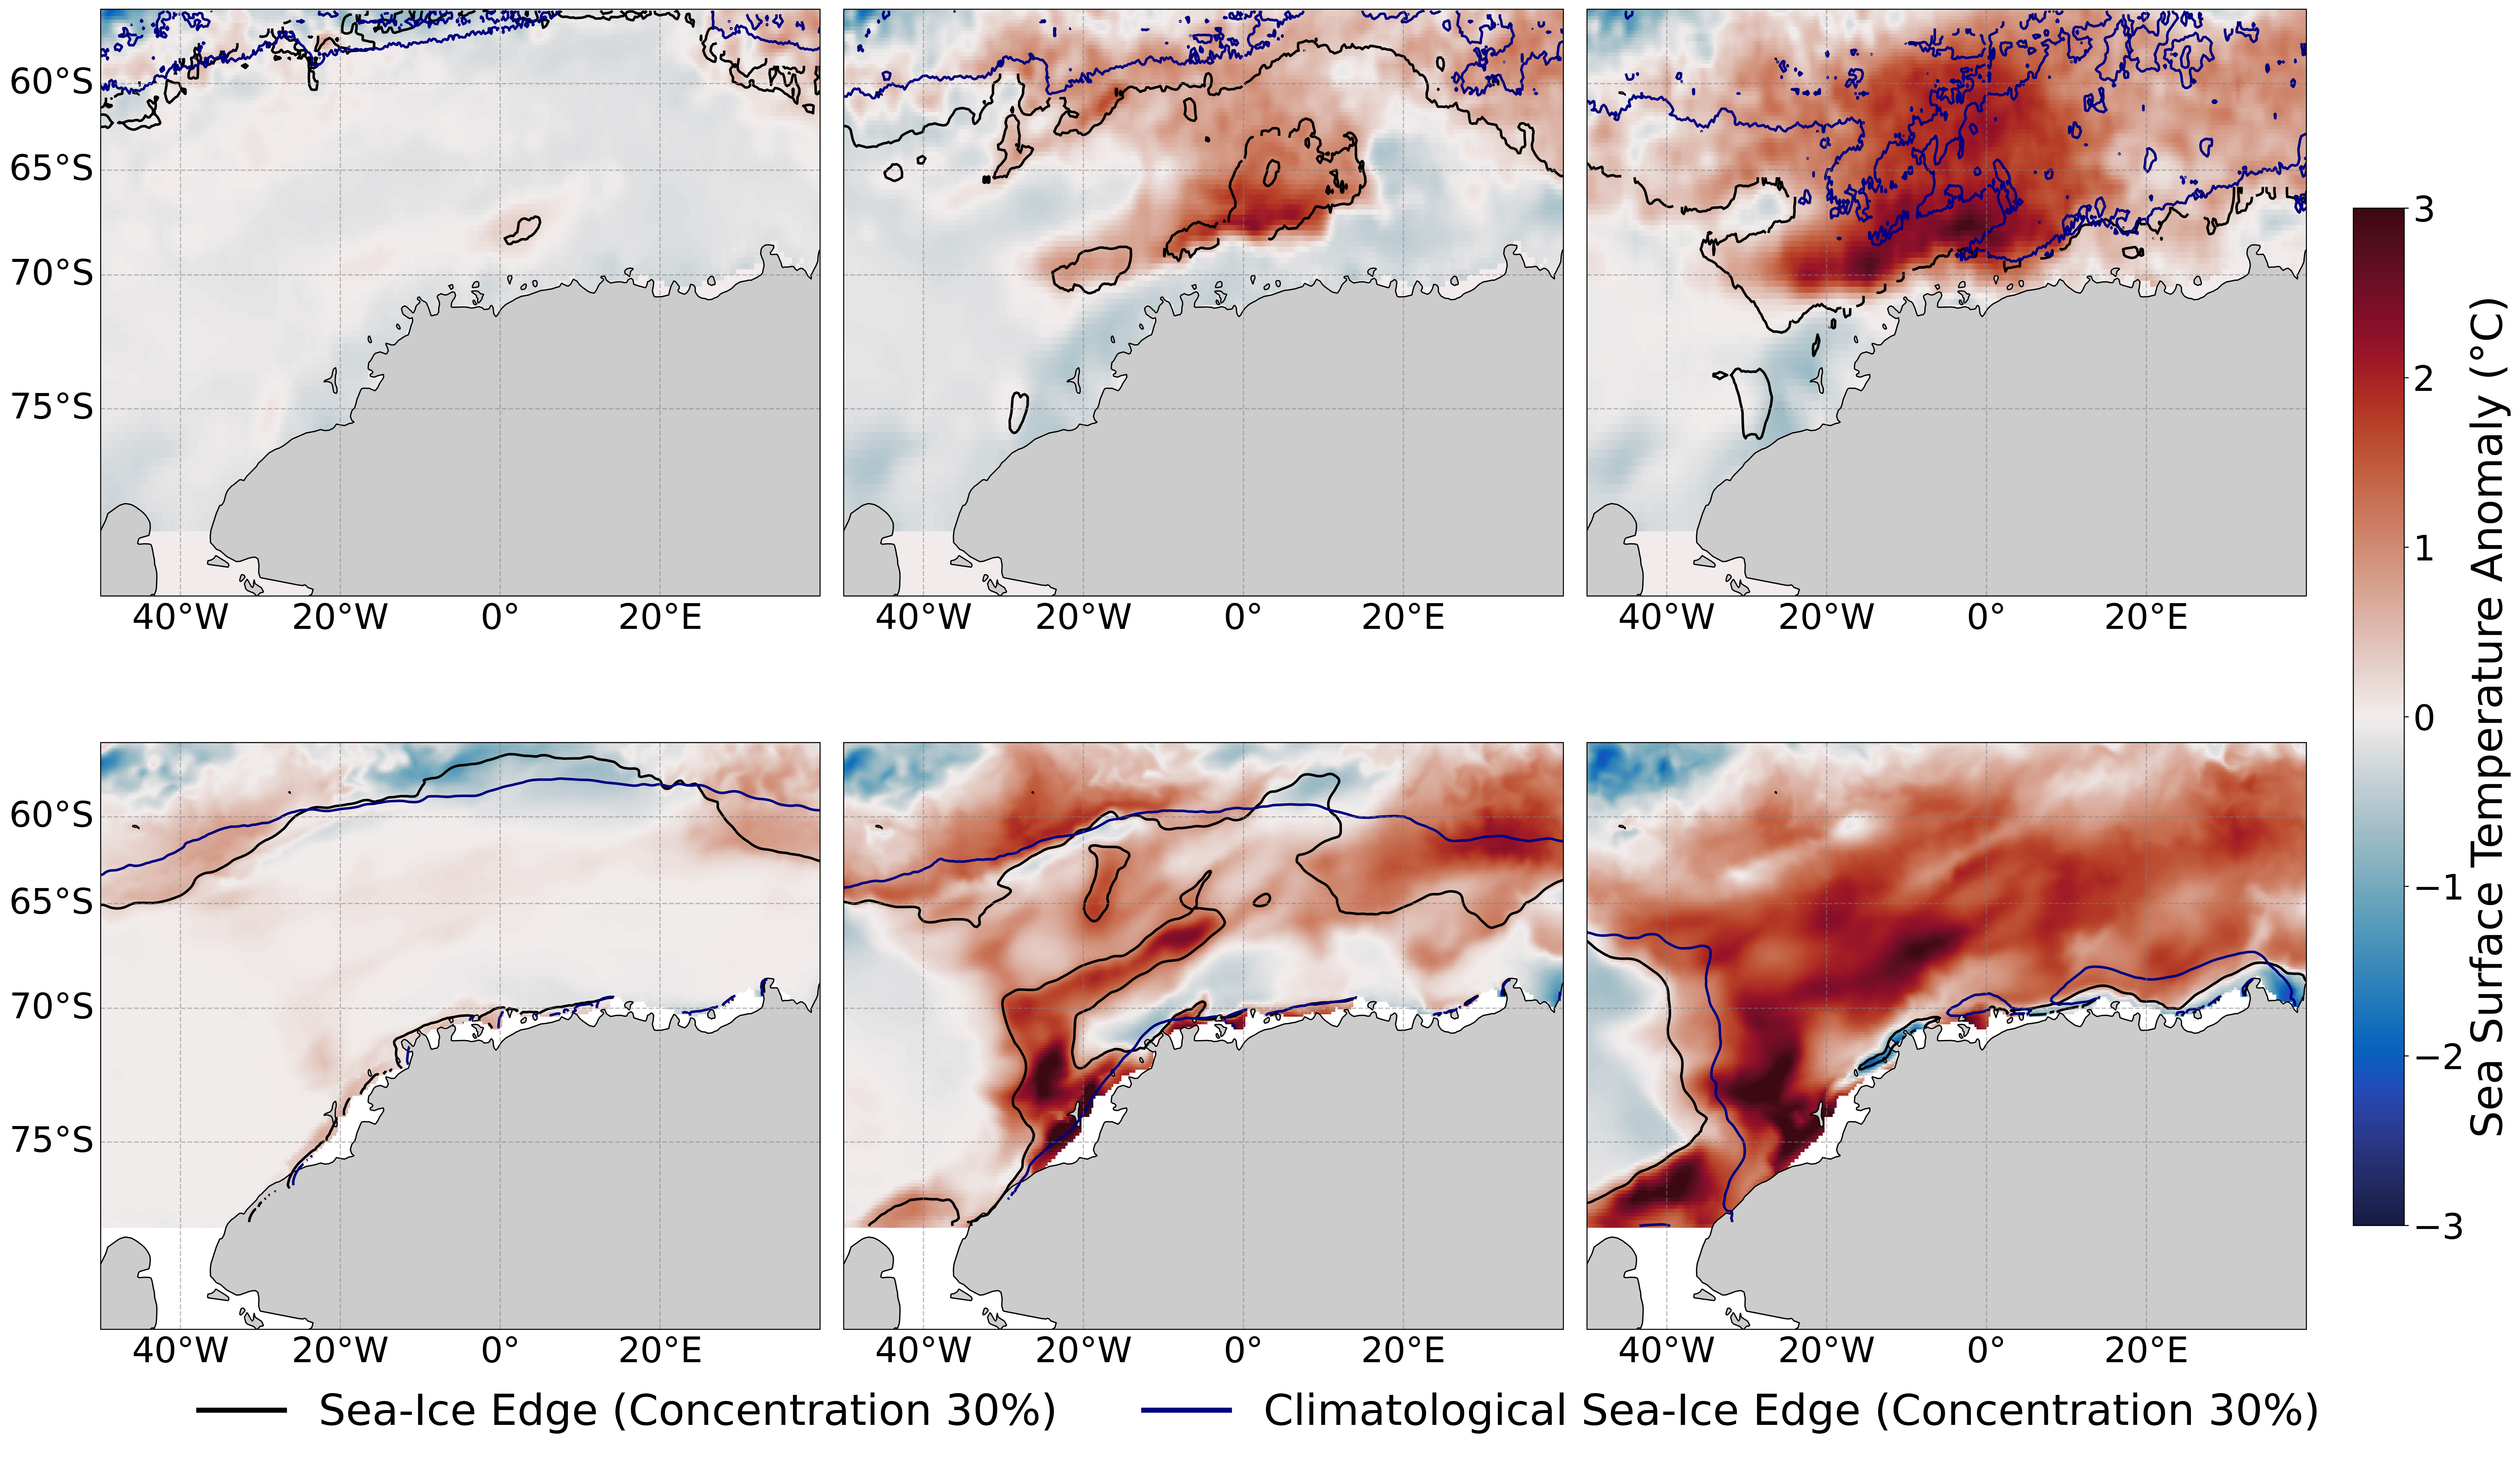

In [38]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.patches as mpatches
import cmocean.cm as cm
import pandas as pd
import calendar
import matplotlib.lines as mlines

# -----------------------------
# Parameters
# -----------------------------
months_oisst = pd.date_range("2016-11-01", "2017-01-01", freq="MS")
months_access = pd.date_range("2016-11-01", "2017-01-01", freq="MS")
extent = [-50, 40, -80, -55]
levels = [0.3]
box_coords = [-15, -68, 25, 5]  # study box [lon, lat, width, height]

# -----------------------------
# Font sizes
# -----------------------------
panel_title_size = 28  # month titles above each map
grid_label_size = 24   # cartopy gridline labels
colorbar_label_size = 28
legend_size = 28

# -----------------------------
# Create figure
# -----------------------------
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(28, 16),
    subplot_kw={'projection': ccrs.Mercator()}
)
axes = axes.flatten()

# -----------------------------
# Panel C: OISST
# -----------------------------
for i, month_start in enumerate(months_oisst):
    ax = axes[i]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cft.NaturalEarthFeature("physical", "land", "50m",
                                           edgecolor="black", facecolor="0.8", linewidth=0.5))
    ax.coastlines(resolution="50m")

    # OISST SSTA
    so_data = satellite_data.sel(lat=slice(-90, -50), lon=slice(0, 360)).sel(
        time=slice(str(month_start.date()), str((month_start + pd.offsets.MonthEnd(1)).date()))
    ).mean("time")
    ssta = so_data.ssta.assign_coords(geolat_t=so_data.lat, geolon_t=so_data.lon)
    im = ssta.plot(x="geolon_t", y="geolat_t", ax=ax, transform=ccrs.PlateCarree(),
                   vmin=-3, vmax=3, cmap=cm.balance, add_colorbar=False)

    # Sea-ice contours
    ice_avg = sea_ice.icec.sel(time=slice(str(month_start.date()),
                                          str((month_start + pd.offsets.MonthEnd(1)).date()))).mean("time")
    clim_avg = climatology_ice.sel(time=slice(str(month_start.date()),
                                              str((month_start + pd.offsets.MonthEnd(1)).date()))).mean("time")
    ice_avg.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=levels,
                         colors='black', linewidths=2, add_colorbar=False)
    clim_avg.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=levels,
                          colors='navy', linewidths=2, add_colorbar=False)

    # # Study box
    # ax.add_patch(mpatches.Rectangle(box_coords[:2], box_coords[2], box_coords[3],
    #                                 linewidth=4, edgecolor='#57cfd8', linestyle='--',
    #                                 facecolor='none', transform=ccrs.PlateCarree(), zorder=5))


    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray',
                      alpha=0.5, linestyle='--')
    gl.left_labels = i % 3 == 0
    gl.bottom_labels = True
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 28}
    gl.ylabel_style = {'size': 28}

# -----------------------------
# Panel D: ACCESS-OM2
# -----------------------------
for i, month_start in enumerate(months_access):
    ax = axes[i + 3]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cft.NaturalEarthFeature("physical", "land", "50m",
                                           edgecolor="black", facecolor="0.8", linewidth=0.5))
    ax.coastlines(resolution="50m")

    # ACCESS SSTA
    ssta = SSTa.sst.sel(time=slice(str(month_start.date()),
                                   str((month_start + pd.offsets.MonthEnd(1)).date()))).mean('time')
    im = ssta.plot(x="lon", y="lat", ax=ax, transform=ccrs.PlateCarree(),
                   vmin=-3, vmax=3, cmap=cm.balance, add_colorbar=False)

    # Sea-ice contours
    ice_mean = access_aice.sel(time=slice(str(month_start.date()),
                                          str((month_start + pd.offsets.MonthEnd(1)).date()))).mean('time')
    clim_mean = access_clim_aice.sel(time=slice(str(month_start.date()),
                                                str((month_start + pd.offsets.MonthEnd(1)).date()))).mean('time')
    ice_mean.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=levels,
                          colors='black', linewidths=2, add_colorbar=False)
    clim_mean.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=levels,
                           colors='navy', linewidths=2, add_colorbar=False)

    # Study box
    # ax.add_patch(mpatches.Rectangle(box_coords[:2], box_coords[2], box_coords[3],
    #                                 linewidth=4, edgecolor='#57cfd8', linestyle='--',
    #                                 facecolor='none', transform=ccrs.PlateCarree(), zorder=5))


    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray',
                      alpha=0.5, linestyle='--')
    gl.left_labels = i % 3 == 0
    gl.bottom_labels = True
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 28}
    gl.ylabel_style = {'size': 28}

# -----------------------------
# Shared vertical colorbar
# -----------------------------
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('Sea Surface Temperature Anomaly (°C)', fontsize=34)
cbar.ax.tick_params(labelsize=colorbar_label_size)

# -----------------------------
# Legend below panels
# -----------------------------
sic_line = mlines.Line2D([], [], color='black', linewidth=4, linestyle='-', label='Sea-Ice Edge (Concentration 30%)')
clim_line = mlines.Line2D([], [], color='navy', linewidth=4, linestyle='-', label='Climatological Sea-Ice Edge (Concentration 30%)')

fig.legend(handles=[sic_line, clim_line],
           loc='lower center', bbox_to_anchor=(0.5, -0.02),
           ncol=3, frameon=False, fontsize=34)

plt.tight_layout(rect=[0, 0.05, 0.92, 1])
plt.subplots_adjust(hspace=0.25)

plt.savefig('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/Weddell_Sea_MHW_Evolution.png',
            dpi=800, bbox_inches='tight', pad_inches=0.1)

plt.show()
